In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/home/chenxupeng/projects/DIP


- [x] implement  https://github.com/Silver-Shen/Causally-Regularized-Learning
- [x] test on training data
- [ ] multi class
- [x] numba accelarate

## Notes:
$$
\begin{array} { c } { P ( Y = k | X = x ) = \frac { \exp \left( \beta _ { k , 0 } + x ^ { T } \beta _ { k } \right) } { 1 + \sum _ { l = 1 } ^ { K - 1 } \exp \left( \beta _ { l , 0 } + x ^ { T } \beta _ { l } \right) } } \\ { \text { for } k = 1 , \ldots , K - 1 } \\ { P ( Y = K | X = x ) = \frac { 1 } { 1 + \sum _ { l = 1 } ^ { K - 1 } \exp \left( \beta _ { l , 0 } + x ^ { T } \beta _ { l } \right) } } \end{array}
$$

$\beta$ should be a matrix with **feature_num** * **class_num shape**

In [6]:
def oneHotEncoding(y, numOfClasses):
    """
    Convert a vector into one-hot encoding matrix where that particular column value is 1 and rest 0 for that row.
    :param y: Label vector
    :param numOfClasses: Number of unique labels
    :return: one-hot encoding matrix
    """
    y = np.asarray(y, dtype='int32')
    if len(y) > 1:
        y = y.reshape(-1)
    if not numOfClasses:
        numOfClasses = np.max(y) + 1
    yMatrix = np.zeros((len(y), numOfClasses))
    yMatrix[np.arange(len(y)), y] = 1
    return yMatrix
    

In [19]:
def sigmoid(x):
    #z = np.dot(X,W)
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x,axis=1)
    sum_exp_x= sum_exp_x.reshape((x.shape[0],1))
    sigmoid = exp_x / sum_exp_x
    return sigmoid

In [125]:
feature_num = 20
sample_num = 500
class_num = 10
eps=10e-3
X = 2*np.round(np.random.rand(sample_num, feature_num))-1; # 1000 samples and 20 features
beta_true = np.random.random([feature_num, class_num]);
Y = sigmoid(np.dot(X,beta_true))
lambda0 = 1; #Logistic loss
lambda1 = 0.1; #Balancing loss
lambda2 = 1; #L_2 norm of sample weight
lambda3 = 0; #L_2 norm of beta
lambda4 = 0.001; #L_1 norm of bata
lambda5 = 1; #Normalization of sample weight
MAXITER = 1000;
ABSTOL = 1e-3;
W_init = np.random.rand(sample_num, 1);
beta_init = 0.5*np.ones([feature_num, class_num]);

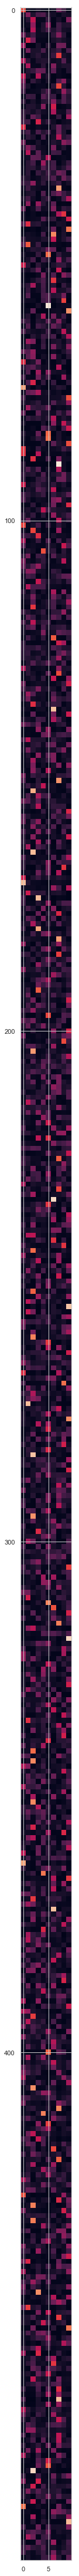

In [49]:
fig,ax=plt.subplots(1,figsize=(10,80))
ax.imshow(Y)

In [50]:
Y.sum(axis=1) # each sample's 10 classes probs should sum to 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

- [ ] TODO: softmax more complex

def sigmoid(x):
    return 1/(1+np.exp(-x))

## J_cost
- [ ] TODO: softmax have different lambda0 term

Calculate the loss function without the non-differentiable part

In [130]:

W = W_init
beta = beta_init

In [52]:
# to implement softmax, change lambda0 term with softmax loss

def softmaxEquation(scores):
    """
    It calculates a softmax probability
    :param scores: A matrix(wt * input sample)
    :return: softmax probability
    """
    scores -= np.max(scores)
    prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T
    return prob

def computeLoss(x, yMatrix,wt,regStrength):
    """
    It calculates a cross-entropy loss and gradient to update the weights.
    :param x: An input sample
    :param yMatrix: Label as one-hot encoding
    :return:
    """
    numOfSamples = x.shape[0]
    scores = np.dot(x, wt)
    prob = softmaxEquation(scores)

    loss = -np.log(np.max(prob)) * yMatrix
    totalLoss = np.sum(loss) / numOfSamples
    grad = ((-1 / numOfSamples) * np.dot(x.T, (yMatrix - prob))) 
    return totalLoss, grad

- logistic regression
$$
\begin{aligned} l ( \beta ) & = \sum _ { i = 1 } ^ { N } \left\{ y _ { i } \log p \left( x _ { i } ; \beta \right) + \left( 1 - y _ { i } \right) \log \left( 1 - p \left( x _ { i } ; \beta \right) \right) \right\} \\ & = \sum _ { i = 1 } ^ { N } \left\{ y _ { i } x _ { i } ^ { T } \beta - \log \left( 1 + \exp \left( x _ { i } ^ { T } \beta \right) \right) \right\} \end{aligned}
$$

- softmax regression
$$
\sum _ { k = 1 } ^ { K } y _ { k } ^ { ( i ) } \log \left( \hat { p } _ { k } ^ { ( i ) } \right)
$$

In [182]:
def cross_entropy_loss(W,X,Y,beta):
    '''
    part of J_loss first term
    '''
    n = X.shape[0]
    Y_cap = sigmoid(X@beta)
    #weight_term = (W*W).reshape(-1,1)
    #print (weight_term.shape,(Y.reshape(-1,1)*np.log(Y_cap)).shape)
    loss = np.sum((W*W)*(Y*np.log(Y_cap)))
    return loss

In [175]:
cross_entropy_loss(W,X,Y,beta)

-382.6933796528916

In [256]:
#lambda0*sum((W*W)*(np.log(1+np.exp(X@beta))-Y*(X@beta)))
def J_cost(W,beta,X,Y,lambda0, lambda1, lambda2, lambda3, lambda5):
    return lambda0*cross_entropy_loss(W,X,Y,beta) \
         +lambda1*sum(balance_cost(W,X)) \
         +lambda2*((W*W).T@(W*W)) \
         +lambda3*sum(beta**2) \
         +lambda5*(sum(W*W)-1)**2

In [70]:
J_cost(W,beta,X,Y,lambda0, lambda1, lambda2, lambda3, lambda5)

array([[24332.18264953]])

## balance cost
- [ ] TODO: it seems do not need to change, means than we can adapt this function into any gradient descent problem

In [255]:
def balance_cost(W=None,X=None,*args,**kwargs):
    m = X.shape[1]
    f_x=np.zeros([m,1])
    for i in np.arange(0,m):
        X_sub=np.copy(X)
        X_sub[:,i]=0
        I=(X[:,i] > 0).astype('double')+eps
        loss=( np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ) / (np.dot((np.multiply(W,W)).T,I.reshape(-1,1)))\
            -(np.dot(X_sub.T,(np.multiply((np.multiply(W,W)),(1 - I.reshape(-1,1)))))) / (np.dot((np.multiply(W,W)).T,(1 - I.reshape(-1,1))))
        #print (loss.shape)
        f_x[i]=np.dot(loss.T,loss)
    return f_x


In [58]:
balance_cost(W,X)

array([[0.38730847],
       [0.41165626],
       [0.39316231],
       [0.2727617 ],
       [0.31718681],
       [0.44008927],
       [0.37368856],
       [0.21282965],
       [0.19291022],
       [0.16060995],
       [0.44438877],
       [0.15128009],
       [0.29727955],
       [0.33768393],
       [0.20408237],
       [0.35794777],
       [0.30523414],
       [0.38001066],
       [0.2351875 ],
       [0.28573664]])

## balance_grad.m

In [59]:
@jit
def balance_grad(W=None,X=None,*args,**kwargs):
    n,m=X.shape

    g_w=np.zeros([n,m])
    for i in range(0,m):
        X_sub = np.copy(X)
        X_sub[:,i] = 0 # the ith column is treatment
        I = (X[:,i]>0).reshape(-1,1).astype('double')+eps
        J1 = (X_sub.T@((W*W)*I.reshape(-1,1)))/((W*W).T@(I.reshape(-1,1))) \
            -(X_sub.T@((W*W)*(1-I).reshape(-1,1)))/((W*W).T@(1-I).reshape(-1,1))
        dJ1W = 2*(X_sub.T*((W*I)@np.ones([1,m])).T*((W*W).T@I) \
                  -(X_sub.T@(((W*W)*I)@(W*I).T)))/((W*W).T@I)**2 \
                  -2*(X_sub.T*((W*(1-I))@np.ones([1,m])).T*((W*W).T@(1-I)) \
                  -((X_sub.T@( (W*W) * (1-I) )) @  (W*(1-I) ).T ))/((W*W).T@(1-I))**2
        g_w[:,i] = (2 * dJ1W.T @ J1).ravel()

    return g_w

In [61]:
balance_grad(W,X).shape

(500, 20)

## prox_l1.m

- [ ] TODO: it is also universal?

In [62]:
@jit
def prox_l1(v=None,lambda_=None,*args,**kwargs):
    x=np.fmax(0,v - lambda_) - np.fmax(0,- v - lambda_)
    return x

## main function

- [ ] TODO: careful change

In [137]:
def grad_CE(lambda0,W,X,Y,beta):
    '''
    part of J_loss's first term grad
    '''
    n = X.shape[0]
    Y_cap = sigmoid(X@beta)
    #original sigmoid(X@beta)-Y)*(W*W)).T@X
    grad = (lambda0*((Y_cap-Y)*(W*W)).T@X).T
    return grad

In [88]:
grad_CE(lambda0,W,X,Y,beta).shape

(20, 10)

<span class="burk">TODO</span>: 
- [x] grad_beta 
- [x] grad_W
- [x] 要根据grad_CE，对比cross_entropy_loss和原loss改
- [ ] 改J_loss迭代时的判别条件，grad_beta.T@(z-beta) 现在不是scalar 是class_num*class_num
prox_l1在控制什么？是L_1 norm of bata？
- [ ] J_cost(z, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5) z改了之后如何修改
- [ ] 2*lambda0*Y*np.log(sigmoid(X@beta))*W 导致grad_W维度变了，所以上面的z因为prox变了，维度不匹配，注意从原loss推导保证维度不变，，

In [90]:
n = X.shape[0]
def sigmoid(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x,axis=1)
    sum_exp_x= sum_exp_x.reshape((x.shape[0],1))
    sigmoid = exp_x / sum_exp_x
    return sigmoid

lambda0*np.sum((W*W)*Y*np.log(sigmoid(X@beta))) #NEW CE

-363.45200780475614

In [91]:
#Original loss: lambda0*np.sum((W*W)*(np.log(1+np.exp(X@beta))-Y*(X@beta))) 
#Original   grad_beta =     lambda0*(((sigmoid(X@beta)-Y)*(W*W)).T@X).T  
grad_beta = grad_CE(lambda0,W,X,Y,beta)

#Original loss: lambda0*np.sum((W*W)*(np.log(1+np.exp(X@beta))-Y*(X@beta))) 
#Original  grad_W = 2*lambda0*(np.log(1+np.exp(X@beta))-Y*(X@beta))*W
grad_W =   2*lambda0*Y*np.log(sigmoid(X@beta))*W
grad_beta.shape,grad_W.shape

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix

def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))


In [191]:
feature_num = 20
sample_num = 500
class_num = 10
eps=10e-3
X = 2*np.round(np.random.rand(sample_num, feature_num))-1; # 1000 samples and 20 features
beta_true = np.random.random([feature_num, class_num]);
Y = np.random.randint(0,9,500).reshape(-1,1) #sigmoid(np.dot(X,beta_true))
lambda0 = 1; #Logistic loss
lambda1 = 0.1; #Balancing loss
lambda2 = 1; #L_2 norm of sample weight
lambda3 = 0; #L_2 norm of beta
lambda4 = 0.001; #L_1 norm of bata
lambda5 = 1; #Normalization of sample weight
MAXITER = 1000;
ABSTOL = 1e-3;
W_init = np.random.rand(sample_num, 1);
beta_init = 0.5*np.ones([feature_num, class_num]);

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X,Y.astype('int'))
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

number of training samples: 375, test samples: 125


In [195]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
report_metrics(y_test, y_pred)

accuracy = 0.096
recall = [0.15789474 0.25       0.         0.0952381  0.11111111 0.07692308
 0.11764706 0.16666667 0.        ]
precision = [0.2        0.06666667 0.         0.15384615 0.05       0.09090909
 0.4        0.04545455 0.        ]
f1 = [0.17647059 0.10526316 0.         0.11764706 0.06896552 0.08333333
 0.18181818 0.07142857 0.        ]
mcc = 0.0013368562728601418


In [196]:
def cross_entropy_loss(W,X,Y,beta):
    '''
    part of J_loss first term
    '''
    n = X.shape[0]
    Y_cap = sigmoid(X@beta)
    #weight_term = (W*W).reshape(-1,1)
    #print (weight_term.shape,(Y.reshape(-1,1)*np.log(Y_cap)).shape)
    loss = np.sum((W*W)*(Y*np.log(Y_cap)))
    return loss

In [270]:
def mainFunc(X, Y, \
    lambda0, lambda1, lambda2, lambda3, lambda4, lambda5,\
    MAXITER, ABSTOL, W_init, beta_init,paras_save_path=None):

    n,m = X.shape
    W = W_init
    W_prev = np.copy(W)
    beta = beta_init
    beta_prev = np.copy(beta)

    parameter_iter = 0.5
    J_loss = np.ones([MAXITER, 1])*(-1)

    lambda_W = 1
    lambda_beta = 1

    W_All = np.zeros([n, MAXITER])
    beta_All = np.zeros([m, MAXITER])

    
    # Optimization with gradient descent
    for iter in tqdm(range(1,MAXITER+1)):
        
        # Update beta
        y = np.copy(beta)
        beta = beta + (iter/(iter+3))*(beta-beta_prev) # fast proximal gradient
        f_base = J_cost(W, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5)
        grad_beta = grad_CE(lambda0,W,X,Y,beta) \
                   +2*lambda3*beta
        while 1:
            z = prox_l1(beta - lambda_beta*grad_beta, lambda_beta*lambda4)
            print ('beta',J_cost(W, z, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5),f_base , np.sum(grad_beta.T@(z-beta)),\
             (1/(2*lambda_beta))*sum((z-beta)**2))
            #grad_beta.T@(z-beta)
            if J_cost(W, z, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5) \
               <= f_base + np.sum(grad_beta.T@(z-beta)) \
               + (1/(2*lambda_beta))*sum((z-beta)**2):
                break
            lambda_beta = parameter_iter*lambda_beta
            if lambda_beta<eps*eps*eps:
                break

        beta_prev = y
        beta = z
        # Update W
        y = np.copy(W)
        W = W+(iter/(iter+3))*(W-W_prev)
        f_base = J_cost(W, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5)
        print ('test1')
        grad_W = 2*lambda0*Y*np.log(sigmoid(X@beta))*W \
                +lambda1*balance_grad(W, X)@np.ones([m,1]) \
                +4*lambda2*W*W*W \
                +4*lambda5*(sum(W*W)-1)*W
        print ('test2')
        while 1:
            z = prox_l1(W-lambda_W*grad_W, 0)
            print (z.shape)
            print ('W',J_cost(z, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5),\
                   f_base , np.sum(grad_W.T@(z-W)),\
                    (1/(2*lambda_W))*sum((z-W)**2))
            #grad_W.T@(z-W)
            if J_cost(z, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5)\
                    <= f_base + np.sum(grad_W.T@(z-W))+(1/(2*lambda_W+10e-100))*sum((z-W)**2):
                break 
            lambda_W = parameter_iter*lambda_W
            if lambda_W<eps*eps*eps:
                break

        W_prev = y
        W = z
        
        W_All[:,iter-1] = W.ravel()
        beta_All[:,iter-1] = beta.ravel()

        J_loss[iter-1] = J_cost(W, beta, X, Y,\
                              lambda0, lambda1, lambda2, lambda3, lambda5)\
                     + lambda4*sum(abs(beta))
        print (J_loss[iter-1] , J_loss[iter-2])
        if (paras_save_path is not None) & (iter%10==1):
            #'output/models/crlr/somedir'
            if not os.path.exists(paras_save_path):
                os.makedirs(paras_save_path)
            np.savetxt(paras_save_path+'/beta.txt',beta)
            np.savetxt(paras_save_path+'/W.txt',W)
            np.savetxt(paras_save_path+'/J_loss.txt',J_loss)
        if (iter > 1) & ( abs(J_loss[iter-1] - J_loss[iter-2])[0]  < ABSTOL) or (iter == MAXITER):
            break
    W = W*W

    return W, beta, J_loss

In [244]:
f_base = J_cost(W, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5)
lambda_beta = 1
z = prox_l1(beta - lambda_beta*grad_beta, lambda_beta*lambda4)
f_base + grad_beta.T@(z-beta) + (1/(2*lambda_beta))*sum((z-beta)**2)

array([[13614.00065905, 13854.54173009, 13978.63253249, 13815.90896964,
        13945.65751411, 13970.95611385, 13933.12020583, 13831.93626605,
        13791.65313333, 13960.45349887],
       [13854.52866687, 13645.01375407, 13820.53518615, 13877.85153554,
        13854.17121754, 13958.31136596, 13897.7580181 , 13848.57365875,
        13945.21157007, 13994.85571938],
       [13978.62090025, 13820.51904867, 13510.89005773, 13975.09598579,
        13920.5997876 , 13910.08264812, 13879.08504086, 13876.5030067 ,
        13942.50709543, 13882.99129954],
       [13815.91655597, 13877.86953868, 13975.10594116, 13656.51260558,
        13876.82046914, 13788.79074326, 13931.21278304, 13928.37602901,
        13907.21176414, 13939.0129163 ],
       [13945.66233384, 13854.18279987, 13920.60218341, 13876.84387437,
        13729.67621262, 13829.95981004, 13842.16692607, 13930.76536129,
        13906.38613111, 13860.6303284 ],
       [13970.96163116, 13958.32840462, 13910.07282788, 13788.79751598,
   

In [ ]:
def prox_l1(v=None,lambda_=None):
    x=np.fmax(0,v - lambda_) - np.fmax(0,- v - lambda_)
    return x
#prox_l1输出的最终会成为小循环中的新beta

In [218]:
np.fmax(beta - lambda_beta*grad_beta, lambda_beta*lambda4)

array([[-5.29118955, -1.60008736,  6.04240349, -3.0168948 ,  1.33163729,
         1.08109643,  1.93694497,  2.24196092,  0.99816596,  1.27196264],
       [ 3.36171466, -4.71676828, -0.42294623,  5.91425351, -2.22389619,
         4.05181215, -1.02673809,  0.54782394,  2.93819288, -3.42344835],
       [ 0.17863048,  3.47923778,  0.02881023,  1.3612402 ,  3.15001418,
         3.13260724, -1.77160138,  2.20817822, -2.1069944 , -4.66412254],
       [-4.6348411 , -1.13397937, -2.80130799,  2.18424242,  3.2029203 ,
         3.50295381,  2.72290273, -1.74277643, -1.9783191 ,  5.67820472],
       [ 6.82442529,  1.79846633, -3.88895982, -0.90876531, -1.80311503,
        -2.87516321,  5.04877597, -2.88157351,  6.05271758, -2.36480831],
       [-3.93808891,  6.5425408 , -0.33364548, -0.82070218, -0.89953817,
        -3.19310437,  3.28831344,  8.89948704, -2.5932743 , -1.94798788],
       [ 4.15585688,  3.40986765,  2.81348749,  0.78767159,  0.15056303,
        -5.72769724,  0.72932893,  5.19218421

In [271]:
W_init = np.random.rand(X_train.shape[0], 1);
beta_init = 0.5*np.ones([feature_num, class_num]);

W, beta, J_loss = mainFunc(X_train, y_train,\
        lambda0, lambda1, lambda2, lambda3, lambda4, lambda5,\
        1000, ABSTOL, W_init, beta_init,)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

beta [[2389.84435352]] [[2389.84435352]] -4965479.659246893 248269.98645027477
beta [[2389.84435352]] [[2389.84435352]] -2482739.8296234463 124134.99322513738
beta [[2389.84435352]] [[2389.84435352]] -1241369.9148117232 62067.49661256869
beta [[2389.84435352]] [[2389.84435352]] -620685.1041466783 31033.762980366013
beta [[2389.84435352]] [[2389.84435352]] -310342.60890479916 15516.887173329018
beta [[2389.84435352]] [[2389.84435352]] -155171.30445239955 7758.443586664509
beta [[2389.84435352]] [[2389.84435352]] -77585.81896008384 3879.238466720659
beta [[2389.84435352]] [[2389.84435352]] -38793.04633959888 1939.6329193160245
beta [[2389.84435352]] [[2389.84435352]] -19396.640694598318 969.8282121379008
beta [[2389.84435352]] [[2389.84435352]] -9698.32034729916 484.91410606895073
beta [[2389.84435352]] [[2389.84435352]] -4849.1601736495795 242.45705303447522
beta [[2389.84435352]] [[2389.84435352]] -2424.58008682479 121.22852651723764
beta [[2389.84435352]] [[2389.84435352]] -1212.29004

ValueError: operands could not be broadcast together with shapes (20,10) (10,1) 

In [288]:
z.shape, W.shape

((500, 10), (500, 1))

In [289]:
grad_W = 2*lambda0*Y*np.log(sigmoid(X@beta))*W \
                +lambda1*balance_grad(W, X)@np.ones([X.shape[1],1]) \
                +4*lambda2*W*W*W \
                +4*lambda5*(sum(W*W)-1)*W
lambda_W=1
z = prox_l1(W-lambda_W*grad_W, 0)
J_cost(z, beta, X, Y, lambda0, lambda1, lambda2, lambda3, lambda5)
                   

balance (20, 10) (10, 1)


ValueError: operands could not be broadcast together with shapes (20,10) (10,1) 

In [286]:
def balance_cost(W=None,X=None,*args,**kwargs):
    m = X.shape[1]
    f_x=np.zeros([m,1])
    for i in np.arange(0,m):
        X_sub=np.copy(X)
        X_sub[:,i]=0
        I=(X[:,i] > 0).astype('double')+eps
        print ('balance',( np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ).shape,\
               (np.dot((np.multiply(W,W)).T,I.reshape(-1,1))).shape)
         
        
        loss=( np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ) / (np.dot((np.multiply(W,W)).T,I.reshape(-1,1)))\
            -(np.dot(X_sub.T,(np.multiply((np.multiply(W,W)),(1 - I.reshape(-1,1)))))) / (np.dot((np.multiply(W,W)).T,(1 - I.reshape(-1,1))))
        #print (loss.shape)
        f_x[i]=np.dot(loss.T,loss)
    return f_x


In [274]:
X_sub=np.copy(X)
X_sub[:,0]=0
I=(X[:,0] > 0).astype('double')+eps

In [277]:
( np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ) / (np.dot((np.multiply(W,W)).T,I.reshape(-1,1)))\
        -(np.dot(X_sub.T,(np.multiply((np.multiply(W,W)),(1 - I.reshape(-1,1)))))) / (np.dot((np.multiply(W,W)).T,(1 - I.reshape(-1,1))))

array([[ 0.        ],
       [-0.23464869],
       [-0.21352383],
       [-0.09310426],
       [-0.1121662 ],
       [-0.02299837],
       [ 0.09378211],
       [ 0.02552632],
       [ 0.06420116],
       [-0.03598019],
       [ 0.01770026],
       [-0.02633627],
       [-0.22665082],
       [-0.0214175 ],
       [-0.05105503],
       [-0.00787399],
       [ 0.0141895 ],
       [ 0.08536466],
       [-0.09877685],
       [ 0.15218183]])

In [ ]:
def J_cost(W,beta,X,Y,lambda0, lambda1, lambda2, lambda3, lambda5):
    return lambda0*cross_entropy_loss(W,X,Y,beta) \
         +lambda1*sum(balance_cost(W,X)) \
         +lambda2*((W*W).T@(W*W)) \
         +lambda3*sum(beta**2) \
         +lambda5*(sum(W*W)-1)**2

In [273]:
z.shape,beta.shape

((500, 10), (20, 10))

In [258]:
m = X.shape[1]
f_x=np.zeros([m,1])
for i in np.arange(0,m):
    X_sub=np.copy(X)
    X_sub[:,i]=0
    I=(X[:,i] > 0).astype('double')+eps
    loss=( np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ) / (np.dot((np.multiply(W,W)).T,I.reshape(-1,1)))\
        -(np.dot(X_sub.T,(np.multiply((np.multiply(W,W)),(1 - I.reshape(-1,1)))))) / (np.dot((np.multiply(W,W)).T,(1 - I.reshape(-1,1))))
    #print (loss.shape)
    f_x[i]=np.dot(loss.T,loss)


In [ ]:
np.dot( X_sub.T, np.multiply( np.multiply(W,W),I.reshape(-1,1) ) ) ) / (np.dot((np.multiply(W,W)).T,I.reshape(-1,1)))

In [254]:
z.shape

(500, 10)

In [ ]:
f_base , np.sum(grad_W.T@(z-W))

In [428]:
y_pred = (sigmoid(np.dot(X_test,beta))>=0.5).astype('int')
report_metrics(y_test, y_pred)

accuracy = 1.0
recall = 1.0
precision = 1.0
f1 = 1.0
mcc = 1.0
